Необходимо из котировок построить дисконтирующую кривую и проинтерполировать ее.

In [1]:
import pandas
import numpy
from datetime import date
import QuantLib
from scipy.interpolate import interp1d
import matplotlib.pyplot

In [2]:
def makeException():
    raise ValueError("Not implemented")

In [3]:
def getZeroRateFromDiscountingFactor(
    discountingFactor: float,
    yearFraction: float
) -> float:
    return ((1 / discountingFactor) - 1) / yearFraction

In [4]:
def getDiscountingFactorFromRates(
    rate: float,
    yearFraction: float
) -> float:
    return 1 / (1 + yearFraction * rate)

In [5]:
class Calendar:
    def __init__(
        self,
        name: str = "US",
        market: str = "NYSE",
    ):
        if name == "US" and market == "NYSE":
            self.__implementation = QuantLib.UnitedStates(
                QuantLib.UnitedStates.NYSE
            )
        else:
            makeException()

    @staticmethod
    def getQuantlibDate(observationDate: date) -> QuantLib.Date:
        return QuantLib.Date(
            observationDate.day,
            observationDate.month,
            observationDate.year
        )

    @staticmethod
    def getPythonDate(observationDate: QuantLib.Date) -> date:
        return date(
            observationDate.year(),
            observationDate.month(),
            observationDate.dayOfMonth(),
        )

    def isHoliday(self, observationDate: QuantLib.Date) -> bool:
        return self.__implementation.isHoliday(observationDate)

    def advance(
        self,
        observationDate: QuantLib.Date,
        shift: int = 2,
        typePeriod = QuantLib.Days,
    ) -> QuantLib.Date:
        return self.__implementation.advance(
            observationDate,
            QuantLib.Period(shift, typePeriod),
            QuantLib.Following,
            False
        )

In [6]:
class Act360:
    def __init__(self, calendar: Calendar):
        self.__implementation = QuantLib.Actual360()
        self.__calendar = calendar
    
    def getYearFraction(
        self,
        startDate: QuantLib.Date, 
        endDate: QuantLib.Date
    ) -> float:
        return self.__implementation.yearFraction(startDate, endDate)

In [7]:
calendar = Calendar()
dayCount = Act360(calendar)
valueDate = calendar.getQuantlibDate(date(2022, 1, 31))
startDate = calendar.advance(valueDate)
fixingDates = []
yearFractions = []
totalYearFractions = []
discountingCurve = []
zeroRates = []


#### USD_3M_LIBOR - Deposit

In [8]:
fixingDates.append(
    calendar.advance(calendar.advance(startDate, 3, QuantLib.Months))
)
yearFractions.append(dayCount.getYearFraction(valueDate, fixingDates[-1]))
totalYearFractions.append(
    dayCount.getYearFraction(valueDate, fixingDates[-1])
)
discountingCurve.append(
    getDiscountingFactorFromRates(0.003, yearFractions[-1])
)
zeroRates.append(
    getZeroRateFromDiscountingFactor(
        discountingCurve[-1], 
        totalYearFractions[-1]
    )
)

In [9]:
yearFractions

[0.25833333333333336]

In [10]:
discountingCurve

[0.9992256001598762]

In [11]:
zeroRates

[0.0029999999999998843]

In [12]:
totalYearFractions

[0.25833333333333336]

#### USD_3M_LIBOR_3x6 - FRA

In [13]:
fixingDates.append(
    calendar.advance(calendar.advance(fixingDates[-1], 3, QuantLib.Months))
)
yearFractions.append(
    dayCount.getYearFraction(fixingDates[-2], fixingDates[-1])
)
totalYearFractions.append(
    dayCount.getYearFraction(valueDate, fixingDates[-1])
)
discountingCurve.append(
    discountingCurve[-1] * getDiscountingFactorFromRates(
        0.0075,
        yearFractions[-1]
    )
)
zeroRates.append(
    getZeroRateFromDiscountingFactor(
        discountingCurve[-1], 
        totalYearFractions[-1]
    )
)

#### USD_3M_LIBOR_6x9 - FRA

In [14]:
fixingDates.append(
    calendar.advance(calendar.advance(fixingDates[-1], 3, QuantLib.Months))
)
yearFractions.append(
    dayCount.getYearFraction(fixingDates[-2], fixingDates[-1])
)
totalYearFractions.append(
    dayCount.getYearFraction(valueDate, fixingDates[-1])
)
discountingCurve.append(
    discountingCurve[-1] * getDiscountingFactorFromRates(
        0.011, 
        yearFractions[-1]
    )
)
zeroRates.append(
    getZeroRateFromDiscountingFactor(
        discountingCurve[-1], 
        totalYearFractions[-1]
    )
)

#### USD_1Y_3M_LIBOR_1Y_FIX - IRS

In [15]:
def getZeroRateFromIRS(
    swapRate: float,
    lastTotalYearFraction: float,
    zeroRates: list, 
    totalYearFractions: list,
    propotionsCouponOfAnnuity: list,
    propotionLastCoupon: float
) -> float:
    result = 0
    for propotion, zeroRate, yearFraction in zip(
        propotionsCouponOfAnnuity,
        zeroRates, 
        totalYearFractions
    ):
        result += propotion * swapRate * getDiscountingFactorFromRates(
            zeroRate,
            yearFraction
        )
    return (
        (1 + propotionLastCoupon * swapRate) / 
        (1 - result) - 1) / lastTotalYearFraction

In [16]:
fixingDates.append(
    calendar.advance(calendar.advance(fixingDates[-1], 3, QuantLib.Months))
)
lastTotalYearFraction = dayCount.getYearFraction(valueDate, fixingDates[-1])
propotionCouponOfAnnuity = [1/4, 1/4, 1/4]
yearFractions.append(
    dayCount.getYearFraction(fixingDates[-2], fixingDates[-1])
)
zeroRates.append(
    getZeroRateFromIRS(
        0.009, 
        lastTotalYearFraction,
        zeroRates, 
        totalYearFractions,
        propotionCouponOfAnnuity,
        propotionLastCoupon = 1/4
    )
)

totalYearFractions.append(lastTotalYearFraction)
discountingCurve.append(
    discountingCurve[-1] * getDiscountingFactorFromRates(
        zeroRates[-1], 
        yearFractions[-1]
    )
)


#### USD_2Y_3M_LIBOR_1Y_FIX - IRS

In [17]:
fixingDates.append(
    calendar.advance(
        calendar.advance(fixingDates[-1], 1, QuantLib.Years)
    )
)
lastTotalYearFraction = dayCount.getYearFraction(valueDate, fixingDates[-1])
propotionCouponOfAnnuity = [1]
yearFractions.append(
    dayCount.getYearFraction(fixingDates[-2], fixingDates[-1])
)

zeroRates.append(
    getZeroRateFromIRS(
        0.0133, 
        lastTotalYearFraction,
        [zeroRates[-1]], 
        [totalYearFractions[-1]],
        propotionCouponOfAnnuity,
        propotionLastCoupon = 1
    )
)

totalYearFractions.append(lastTotalYearFraction)
discountingCurve.append(
    discountingCurve[-1] * getDiscountingFactorFromRates(
        zeroRates[-1], 
        yearFractions[-1]
    )
)

#### Оставшиеся свопы

In [18]:
previousMaturity = 2
for maturity, swapRate in zip(
    [3, 4, 5, 6, 7, 8, 9, 10],
    [
        0.0153, 0.0163, 0.0169, 0.0173, 
        0.0177, 0.018, 0.0182, 0.0184
    ]
):
    differences = maturity - previousMaturity
    fixingDates.append(
        calendar.advance(
            calendar.advance(fixingDates[-1], differences, QuantLib.Years)
        )
    )
    lastTotalYearFraction = dayCount.getYearFraction(
        valueDate,
        fixingDates[-1]
    )
    propotionCouponOfAnnuity.append(1)
    yearFractions.append(
        dayCount.getYearFraction(fixingDates[-2], fixingDates[-1])
    )
    zeroRates.append(
        getZeroRateFromIRS(
            swapRate, 
            lastTotalYearFraction,
            zeroRates[4:], 
            totalYearFractions[4:],
            propotionCouponOfAnnuity,
            propotionLastCoupon = 1
        )
    )
    totalYearFractions.append(lastTotalYearFraction)
    discountingCurve.append(
        discountingCurve[-1] * getDiscountingFactorFromRates(
            zeroRates[-1], 
            yearFractions[-1]
        )
    )
    
    previousMaturity = maturity

, 12, 15, 20, 25, 30
, 0.0189, 0.0193, 0.0196, 0.0195, 0.0192


#### USD_12Y_3M_LIBOR_1Y_FIX - IRS

In [19]:
fixingDates.append(
    calendar.advance(
        calendar.advance(fixingDates[-1], 2, QuantLib.Years)
    )
)
lastTotalYearFraction = dayCount.getYearFraction(valueDate, fixingDates[-1])
propotionCouponOfAnnuity = [2, 2, 2, 2]
yearFractions.append(
    dayCount.getYearFraction(fixingDates[-2], fixingDates[-1])
)

zeroRates.append(
    getZeroRateFromIRS(
        0.0189, 
        lastTotalYearFraction,
        zeroRates[4::2], 
        totalYearFractions[4::2],
        propotionCouponOfAnnuity,
        propotionLastCoupon = 2
    )
)

totalYearFractions.append(lastTotalYearFraction)
discountingCurve.append(
    discountingCurve[-1] * getDiscountingFactorFromRates(
        zeroRates[-1], 
        yearFractions[-1]
    )
)

#### USD_15Y_3M_LIBOR_1Y_FIX - IRS

In [20]:
fixingDates.append(
    calendar.advance(
        calendar.advance(fixingDates[-1], 3, QuantLib.Years)
    )
)
lastTotalYearFraction = dayCount.getYearFraction(valueDate, fixingDates[-1])
propotionCouponOfAnnuity = [5, 5]
yearFractions.append(
    dayCount.getYearFraction(fixingDates[-2], fixingDates[-1])
)

zeroRates.append(
    getZeroRateFromIRS(
        0.0193, 
        lastTotalYearFraction,
        zeroRates[7::5], 
        totalYearFractions[7::5],
        propotionCouponOfAnnuity,
        propotionLastCoupon = 5
    )
)

totalYearFractions.append(lastTotalYearFraction)
discountingCurve.append(
    discountingCurve[-1] * getDiscountingFactorFromRates(
        zeroRates[-1], 
        yearFractions[-1]
    )
)

#### USD_20Y_3M_LIBOR_1Y_FIX - IRS

In [21]:
fixingDates.append(
    calendar.advance(
        calendar.advance(fixingDates[-1], 5, QuantLib.Years)
    )
)
lastTotalYearFraction = dayCount.getYearFraction(valueDate, fixingDates[-1])
propotionCouponOfAnnuity = [5, 5, 5]
yearFractions.append(
    dayCount.getYearFraction(fixingDates[-2], fixingDates[-1])
)

zeroRates.append(
    getZeroRateFromIRS(
        0.0196, 
        lastTotalYearFraction,
        [*zeroRates[7::5], zeroRates[-1]], 
        [*totalYearFractions[7::5], totalYearFractions[-1]], 
        propotionCouponOfAnnuity,
        propotionLastCoupon = 5
    )
)

totalYearFractions.append(lastTotalYearFraction)
discountingCurve.append(
    discountingCurve[-1] * getDiscountingFactorFromRates(
        zeroRates[-1], 
        yearFractions[-1]
    )
)

#### USD_25Y_3M_LIBOR_1Y_FIX - IRS

In [22]:
fixingDates.append(
    calendar.advance(
        calendar.advance(fixingDates[-1], 5, QuantLib.Years)
    )
)
lastTotalYearFraction = dayCount.getYearFraction(valueDate, fixingDates[-1])
propotionCouponOfAnnuity = [5, 5, 5, 5]
yearFractions.append(
    dayCount.getYearFraction(fixingDates[-2], fixingDates[-1])
)

zeroRates.append(
    getZeroRateFromIRS(
        0.0195, 
        lastTotalYearFraction,
        [*zeroRates[7::5], *zeroRates[-1:-3:-1]], 
        [*totalYearFractions[7::5], *totalYearFractions[-1:-3:-1]],  
        propotionCouponOfAnnuity,
        propotionLastCoupon = 5
    )
)

totalYearFractions.append(lastTotalYearFraction)
discountingCurve.append(
    discountingCurve[-1] * getDiscountingFactorFromRates(
        zeroRates[-1], 
        yearFractions[-1]
    )
)

#### USD_30Y_3M_LIBOR_1Y_FIX - IRS

In [23]:
fixingDates.append(
    calendar.advance(
        calendar.advance(fixingDates[-1], 5, QuantLib.Years)
    )
)
lastTotalYearFraction = dayCount.getYearFraction(valueDate, fixingDates[-1])
propotionCouponOfAnnuity = [15]
yearFractions.append(
    dayCount.getYearFraction(fixingDates[-2], fixingDates[-1])
)

zeroRates.append(
    getZeroRateFromIRS(
        0.0192, 
        lastTotalYearFraction,
        [zeroRates[-3]], 
        [totalYearFractions[-3]], 
        propotionCouponOfAnnuity,
        propotionLastCoupon = 15
    )
)

totalYearFractions.append(lastTotalYearFraction)
discountingCurve.append(
    discountingCurve[-1] * getDiscountingFactorFromRates(
        zeroRates[-1], 
        yearFractions[-1]
    )
)

# !!Исправить прибавление к каждой fixingDates два дня

In [24]:
discountingCurve

[0.9992256001598762,
 0.9972311378841079,
 0.9943750717059303,
 0.9921032865297462,
 0.9791767389128327,
 0.9693244821642714,
 0.9575326288217197,
 0.9445708098635657,
 0.930726346655931,
 0.9162217574948991,
 0.9013157439473816,
 0.8860217303325073,
 0.8704358096192266,
 0.8415042751801654,
 0.7905404087231805,
 0.7091669965211074,
 0.6333960393446224,
 0.5720346854340879]

In [25]:
yearFractions

[0.25833333333333336,
 0.26666666666666666,
 0.2611111111111111,
 0.26666666666666666,
 1.0194444444444444,
 1.0277777777777777,
 1.025,
 1.0194444444444444,
 1.025,
 1.025,
 1.0194444444444444,
 1.025,
 1.0277777777777777,
 2.033333333333333,
 3.05,
 5.0777777777777775,
 5.083333333333333,
 5.080555555555556]

In [26]:
zeroRates

[0.0029999999999998843,
 0.005288666666666856,
 0.007195862023674873,
 0.008587003517032423,
 0.012949646073960557,
 0.009889340169906495,
 0.012014470125808117,
 0.013460706884934698,
 0.014512099525098432,
 0.015444752951927612,
 0.016222619831734245,
 0.01684043221712032,
 0.017421939039428562,
 0.016908557584658673,
 0.021136761926077916,
 0.022597496136900756,
 0.023533083792137862,
 0.021113555088625058]

In [27]:
totalYearFractions

[0.25833333333333336,
 0.525,
 0.7861111111111111,
 1.0527777777777778,
 2.0722222222222224,
 3.1,
 4.125,
 5.144444444444445,
 6.169444444444444,
 7.194444444444445,
 8.213888888888889,
 9.238888888888889,
 10.266666666666667,
 12.3,
 15.35,
 20.427777777777777,
 25.511111111111113,
 30.591666666666665]

In [28]:
def getInterpolatatedDiscountingFactor(
    abscisa: float, 
    abscissas: list, 
    ordinates: list
):
    abscissas = numpy.array(abscissas)
    ordinates = numpy.log(numpy.array(ordinates))
    return numpy.exp(
        interp1d(
            abscissas,
            ordinates,
            kind='linear', 
            fill_value="extrapolate"
        )(abscisa)
    )

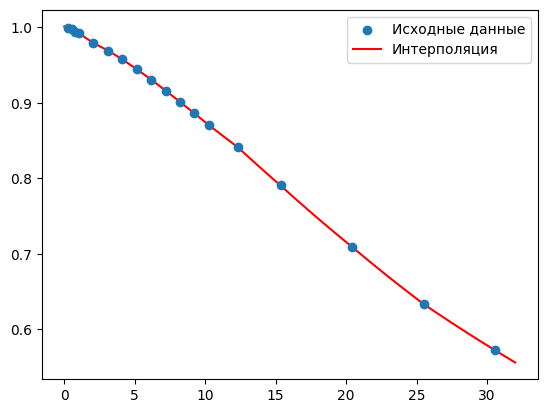

In [30]:
mesh = numpy.linspace(0, 32, 100)         
values = []
for x in mesh:
    values.append(
        getInterpolatatedDiscountingFactor(
            x,
            totalYearFractions,
            discountingCurve
        )
    )

matplotlib.pyplot.scatter(
    totalYearFractions,
    discountingCurve, 
    label="Исходные данные",
    zorder=2
)
matplotlib.pyplot.plot(
    mesh, 
    values, 
    '-', 
    label="Интерполяция", 
    c="r", 
    zorder=1
) 
matplotlib.pyplot.legend()
matplotlib.pyplot.show()